# Predicting West Nile Virus outbreak for kaggle competition

https://www.kaggle.com/c/predict-west-nile-virus

Problem Statement

The City of Chicago and the Chicago Department of Public Health (CDPH) established a surveillance and control program in 2004, in an effort to stop the spread of  West Nile virus.

West Nile Virus was first observed in the West Nile district of Uganda in 1937 and spread to Europe , west Asia, Middle East and North America. West Nile Virus is carried by birds and most commonly spread to humans through mosquitoes. Around 20% of infected patients with the virus develop conditions ranging from persistent fever, to serious illness that can result in death.
In the first ten years since the virus arrived in the U.S., over 1,100 deaths occurred. In 2012, there was a widespread outbreak with the highest death toll and second-highest total case numbers. 

Given weather, location and spraying data, the City of Chicago wants to have more effective and accurate measure to predict outbreaks of the virus and prevent the transmission.

In base of the result obtained from program, the City decides when and where the City will spray airborne pesticides to control mosquito population.

In [1]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.pipeline import Pipeline
import pandas as pd
from keras.datasets import mnist ##For loading the dataset
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import theano
import numpy as np
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


# Load Datasets
will use the  datasets provided https://www.kaggle.com/c/predict-west-nile-virus/data
Train.csv
weather.csv
test.csv
spray.csv
sampleSubmission.csv (used for submitting results)

In [2]:
train=pd.read_csv('./Data/train.csv')
spray=pd.read_csv('./Data/spray.csv')
weather=pd.read_csv('./Data/weather.csv')
test=pd.read_csv('./Data/test.csv')
kaggle_Submission=pd.read_csv('./data/sampleSubmission.csv')

# Clean and Merge Datasets

# Weather Data

In [3]:
#Drop empty columns
weather = weather.drop([ 'CodeSum','Water1'], axis=1)
weather = weather.drop([ 'Sunrise','Sunset'], axis=1)
weather = weather.drop([ 'Depth','SnowFall'], axis=1)

In [4]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [5]:
# weather data was from two Stations. separate 
#the two stations data and concatenate side by side
#station 1 columns will have postfix _x, Station2 will have _y
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')


# Train and Test Data

In [6]:
#  extract month and day from data
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)

In [7]:
# Alatitude/longitude columns

train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)

In [8]:
# drop address, not needed 
train = train.drop(['Address', 'AddressNumberAndStreet', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

# Merge Train and test with Weather data on Date

In [9]:
# Merge weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)

In [10]:
#Create Dummies for Species, and drop one for avoiding multicolinearity
species_dummies = pd.get_dummies(train.Species, prefix='Species').iloc[:, 1:]
train = pd.concat([train, species_dummies], axis=1)
testspecies_dummies = pd.get_dummies(test.Species, prefix='Species').iloc[:, 1:]
test=pd.concat([test, testspecies_dummies], axis=1)

In [11]:
train = train.drop(['Species'], axis = 1)
test = test.drop(['Species','Species_UNSPECIFIED CULEX'], axis = 1)

In [12]:
#Streets
# Convert categorical data to numbers
from sklearn.preprocessing  import LabelEncoder
lbl = LabelEncoder()
lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

In [13]:
#Number of traps
lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

In [14]:
#dropinf missing values
# drop columns with -1s
train = train.ix[:,(train != -1).any(axis=0)]
test = test.ix[:,(test != -1).any(axis=0)]

# Correlation Matrix

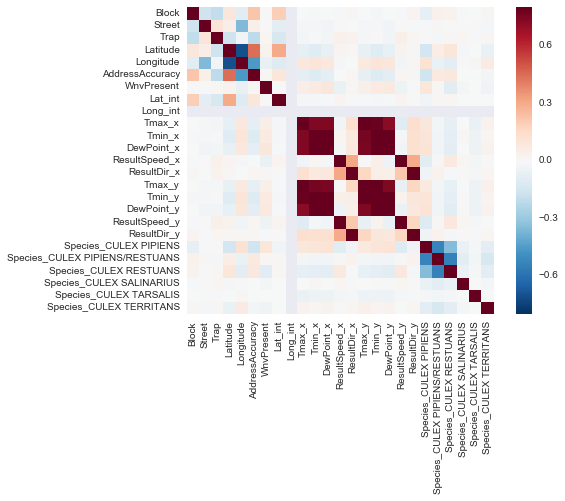

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


corrmap=train.corr()
sns.heatmap(corrmap, vmax=.8, square=True)


High correlation between
AddressAccuracy and Latitude and Longtuide. 

And among the Mosquito species
u'Species_CULEX PIPIENS',u'Species_CULEX PIPIENS/RESTUANS', u'Species_CULEX RESTUANS

In [16]:
train.drop(['AddressAccuracy','Species_CULEX PIPIENS','Species_CULEX RESTUANS'], axis =1, inplace = True)
test.drop(['AddressAccuracy','Species_CULEX PIPIENS','Species_CULEX RESTUANS'], axis =1, inplace = True)

# Model Base Features

In [17]:
X = train.drop(['WnvPresent'],axis=1)
y = train['WnvPresent']
test_X=test   #testdataset does not have WnvPresent

In [18]:
X.shape
X.columns

Index([u'Block', u'Street', u'Trap', u'Latitude', u'Longitude', u'month',
       u'day', u'Lat_int', u'Long_int', u'Tmax_x', u'Tmin_x', u'Tavg_x',
       u'Depart_x', u'DewPoint_x', u'WetBulb_x', u'Heat_x', u'Cool_x',
       u'PrecipTotal_x', u'StnPressure_x', u'SeaLevel_x', u'ResultSpeed_x',
       u'ResultDir_x', u'AvgSpeed_x', u'Tmax_y', u'Tmin_y', u'Tavg_y',
       u'DewPoint_y', u'WetBulb_y', u'Heat_y', u'Cool_y', u'PrecipTotal_y',
       u'StnPressure_y', u'SeaLevel_y', u'ResultSpeed_y', u'ResultDir_y',
       u'AvgSpeed_y', u'Species_CULEX PIPIENS/RESTUANS',
       u'Species_CULEX SALINARIUS', u'Species_CULEX TARSALIS',
       u'Species_CULEX TERRITANS'],
      dtype='object')

In [19]:
def standnormalize(s):
    return StandardScaler().fit_transform(s)
#scale = StandardScaler()
#X = scale.fit_transform(X)
#testX=scale.fit_transform(testX)

# Feature Extraction using Extra Tree 

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
X_normilized=standnormalize(X)
ETC = ExtraTreesClassifier(n_estimators=20)
ETC.fit(X_normilized, y)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

<function matplotlib.pyplot.show>

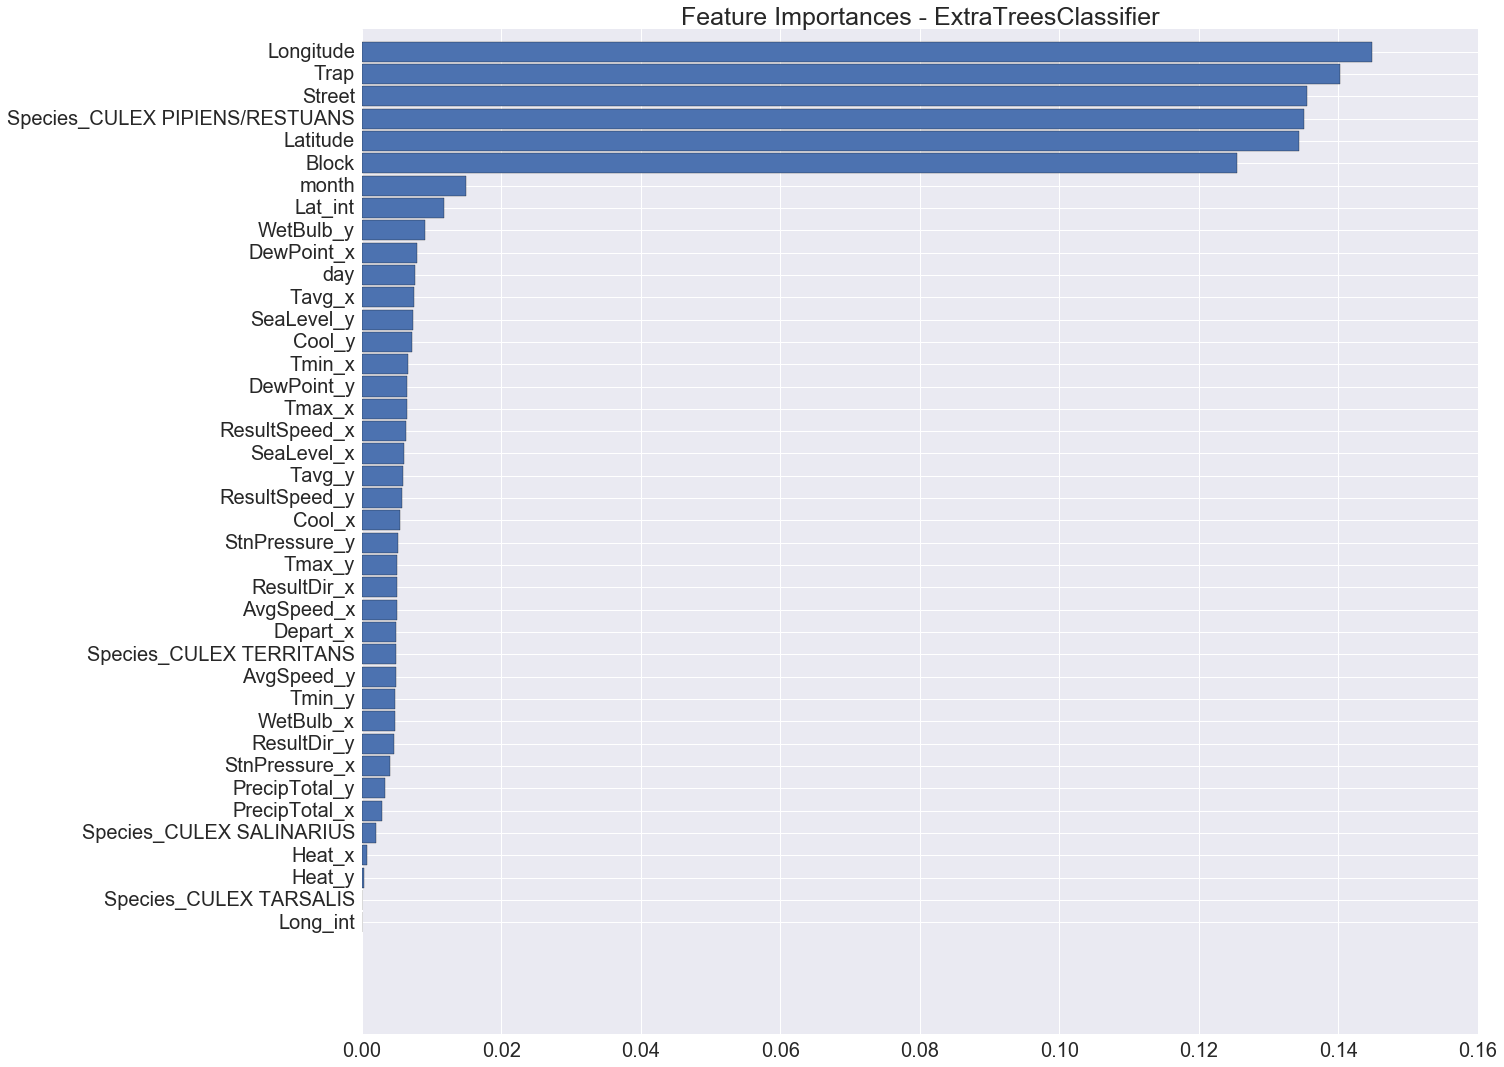

In [21]:
imp = ETC.feature_importances_
indices = np.argsort(imp)[::-1]
names=X.columns

imp, names=zip(*sorted(zip(imp,names)))
plt.figure(figsize=(20,18))
plt.barh(range(len(names)),imp,align='center',height=.9)
plt.yticks(range(len(names)),names,size=20)
plt.xticks(size=20)
plt.title("Feature Importances - ExtraTreesClassifier",size=25)
plt.show


In [22]:
features=np.array(names[20:])
print features

['Tavg_y' 'SeaLevel_x' 'ResultSpeed_x' 'Tmax_x' 'DewPoint_y' 'Tmin_x'
 'Cool_y' 'SeaLevel_y' 'Tavg_x' 'day' 'DewPoint_x' 'WetBulb_y' 'Lat_int'
 'month' 'Block' 'Latitude' 'Species_CULEX PIPIENS/RESTUANS' 'Street'
 'Trap' 'Longitude']


In [23]:
#Selected_Features 20
X_selected = X[features]
y = train['WnvPresent']
test_X_selected=test[features]


+++++++++++++++++++++++++++++++********************?????????????//////////////////////////////////////////////////

# Building  a Binary classification Neural Network model
http://machinelearningmastery.com/5-step-life-cycle-neural-network-models-keras/

Defining the function that creates our model. Our model will have a four fully connected hidden layers.
with input dimention equal to the dimension of the the dataset, and training on 40 neurons all the dimensions in the first hidden layer  and decreasing the number of features/dimensions to 32 and 20 in the consecutive hidden layers.

The weights are initialized using a small Gaussian random number. The Rectifier activation function is used.init='glorot_uniform', Activation('relu')

The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1.

Finally, we are using the logarithmic loss function (binary_crossentropy) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.


# Define model_framework()

In [24]:
def model_framework():
    #Define network type
    model = Sequential()
    
    # Define Layer 1 
    model.add(Dense(40, input_dim= X.shape[1],activation='relu'))
    model.add(Dropout(0.25))
    
    #Layer 2
    model.add(Dense(32, init='glorot_uniform',activation='relu'))
    model.add(Dropout(0.5))
    
    # Layer 3
    model.add(Dense(20, init='glorot_uniform',activation='relu'))
    model.add(Dropout(0.5))
    # Layer 4 /Dense Layer
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer="adam",metrics=['accuracy'])
    return model


# Run Base model

In [25]:
from sklearn.cross_validation import train_test_split
X_normalized=standnormalize(X)
X_train, X_test,y_train,y_test=train_test_split(X_normalized, y, test_size=0.33, random_state=42)

model=model_framework()
model.fit(X_train, y_train, nb_epoch=5, batch_size=16,validation_data=(X_test, y_test))

Train on 7039 samples, validate on 3467 samples
Epoch 1/5
7039/7039 [==============================] - 0s - loss: 0.2582 - acc: 0.9393 - val_loss: 0.1967 - val_acc: 0.9475
Epoch 2/5
7039/7039 [==============================] - 0s - loss: 0.2167 - acc: 0.9476 - val_loss: 0.1894 - val_acc: 0.9475
Epoch 3/5
7039/7039 [==============================] - 0s - loss: 0.2023 - acc: 0.9476 - val_loss: 0.1836 - val_acc: 0.9475
Epoch 4/5
7039/7039 [==============================] - 0s - loss: 0.1934 - acc: 0.9476 - val_loss: 0.1811 - val_acc: 0.9475
Epoch 5/5
7039/7039 [==============================] - 0s - loss: 0.1925 - acc: 0.9476 - val_loss: 0.1838 - val_acc: 0.9475


In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

3008/3467 [=========================>....] - ETA: 0s('loss:', 0.18377751941497986)
('accuracy:', 0.94750504757438569)


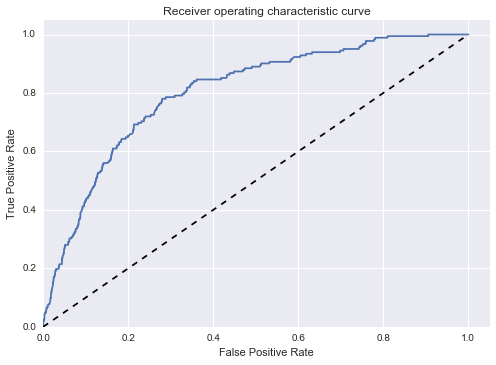

AUC: 0.801939


In [27]:
y_pred=model.predict(X_test)
fpr,tpr, _ = roc_curve(y_test,y_pred)
roc_auc=auc(fpr,tpr)
plt.figure
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()
print('AUC: %f' % roc_auc)

# Run Model with Selected Features

In [28]:
from sklearn.cross_validation import train_test_split
saveX=X #the modelframework refers to the shape of X and will 
X=X_selected
X_normalized=standnormalize(X)
X_train, X_test,y_train,y_test=train_test_split(X_normalized, y, test_size=0.33, random_state=42)

model=model_framework()
model.fit(X_train, y_train, nb_epoch=5, batch_size=16,validation_data=(X_test, y_test))
print X_normalized.shape
X=saveX

Train on 7039 samples, validate on 3467 samples
Epoch 1/5
7039/7039 [==============================] - 0s - loss: 0.3477 - acc: 0.8865 - val_loss: 0.2040 - val_acc: 0.9475
Epoch 2/5
7039/7039 [==============================] - 0s - loss: 0.2372 - acc: 0.9473 - val_loss: 0.1922 - val_acc: 0.9475
Epoch 3/5
7039/7039 [==============================] - 0s - loss: 0.2251 - acc: 0.9476 - val_loss: 0.1870 - val_acc: 0.9475
Epoch 4/5
7039/7039 [==============================] - 0s - loss: 0.2076 - acc: 0.9476 - val_loss: 0.1877 - val_acc: 0.9475
Epoch 5/5
7039/7039 [==============================] - 0s - loss: 0.2029 - acc: 0.9476 - val_loss: 0.1853 - val_acc: 0.9475
(10506, 20)


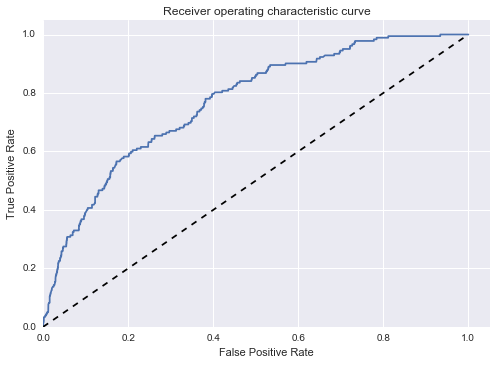

AUC: 0.768165


In [29]:
y_pred=model.predict(X_test)
fpr,tpr, _ = roc_curve(y_test,y_pred)
roc_auc=auc(fpr,tpr)
plt.figure
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()
print('AUC: %f' % roc_auc)

# Tune Batch Size and Number of Epochs with grid search
 http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

The batch size in iterative gradient descent is the number of patterns shown to the network before the weights are 
updated. It is also an optimization in the training of the network, defining how many patterns to read at a time 
and keep in memory.

The number of epochs is the number of times that the entire training dataset is shown to the network during training. 
Here we will evaluate a suite of different mini batch sizes from 16 to 128 and epoaches of 10, 50 & 100.

In [438]:
# Use scikit-learn to grid search the batch size and epochs
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.grid_search import GridSearchCV

X_normalized=standnormalize(X)
model = KerasClassifier(build_fn=model_framework)

batch_size = [16,32,64,128]
epochs = [10,50,100]
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=1,verbose=0)
grid_result = grid.fit(X_normalized, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Epoch 1/10
7004/7004 [==============================] - 0s - loss: 0.2768 - acc: 0.9240     
Epoch 2/10
7004/7004 [==============================] - 0s - loss: 0.1994 - acc: 0.9535     
Epoch 3/10
7004/7004 [==============================] - 0s - loss: 0.1828 - acc: 0.9542     
Epoch 4/10
7004/7004 [==============================] - 0s - loss: 0.1717 - acc: 0.9545     
Epoch 5/10
7004/7004 [==============================] - 0s - loss: 0.1673 - acc: 0.9545     
Epoch 6/10
7004/7004 [==============================] - 0s - loss: 0.1638 - acc: 0.9545     
Epoch 7/10
7004/7004 [==============================] - 0s - loss: 0.1597 - acc: 0.9545     
Epoch 8/10
7004/7004 [==============================] - 0s - loss: 0.1568 - acc: 0.9545     
Epoch 9/10
7004/7004 [==============================] - 0s - loss: 0.1601 - acc: 0.9545     
Epoch 10/10
3502/3502 [==============================] - 0s     
Epoch 1/10
7004/7004 [==============================] - 0s - loss: 0.3485 - acc: 0.9065     
Epoch

ValueError: I/O operation on closed file

In [439]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: 0.947554 using {'nb_epoch': 10, 'batch_size': 64}
0.947554 (0.032175) with: {'nb_epoch': 10, 'batch_size': 16}
0.947554 (0.032175) with: {'nb_epoch': 50, 'batch_size': 16}
0.947554 (0.032175) with: {'nb_epoch': 100, 'batch_size': 16}
0.947554 (0.032175) with: {'nb_epoch': 10, 'batch_size': 32}
0.947554 (0.032175) with: {'nb_epoch': 50, 'batch_size': 32}
0.947554 (0.032175) with: {'nb_epoch': 100, 'batch_size': 32}
0.947554 (0.032175) with: {'nb_epoch': 10, 'batch_size': 64}
0.947554 (0.032175) with: {'nb_epoch': 50, 'batch_size': 64}
0.947554 (0.032175) with: {'nb_epoch': 100, 'batch_size': 64}
0.947554 (0.032175) with: {'nb_epoch': 10, 'batch_size': 128}
0.947554 (0.032175) with: {'nb_epoch': 50, 'batch_size': 128}
0.947554 (0.032175) with: {'nb_epoch': 100, 'batch_size': 128}


# Model with best parameters

In [306]:
(X_normalized).shape
X = train.drop(['WnvPresent'],axis=1)
y = train['WnvPresent']
test_X=test

In [168]:
from sklearn.cross_validation import train_test_split
#X=X_selected
X_normalized=standnormalize(X)
X_train, X_test,y_train,y_test=train_test_split(X_normalized, y, test_size=0.33, random_state=42)

fmodel=model_framework()
fmodel.fit(X_train, y_train, nb_epoch=63, batch_size=128,validation_data=(X_test, y_test))

Train on 7039 samples, validate on 3467 samples
Epoch 1/63
7039/7039 [==============================] - 0s - loss: 0.4701 - acc: 0.8116 - val_loss: 0.2233 - val_acc: 0.9475
Epoch 2/63
7039/7039 [==============================] - 0s - loss: 0.2827 - acc: 0.9359 - val_loss: 0.2030 - val_acc: 0.9475
Epoch 3/63
7039/7039 [==============================] - 0s - loss: 0.2564 - acc: 0.9442 - val_loss: 0.1985 - val_acc: 0.9475
Epoch 4/63
7039/7039 [==============================] - 0s - loss: 0.2370 - acc: 0.9463 - val_loss: 0.1974 - val_acc: 0.9475
Epoch 5/63
7039/7039 [==============================] - 0s - loss: 0.2332 - acc: 0.9454 - val_loss: 0.1941 - val_acc: 0.9475
Epoch 6/63
7039/7039 [==============================] - 0s - loss: 0.2208 - acc: 0.9466 - val_loss: 0.1905 - val_acc: 0.9475
Epoch 7/63
7039/7039 [==============================] - 0s - loss: 0.2176 - acc: 0.9476 - val_loss: 0.1896 - val_acc: 0.9475
Epoch 8/63
7039/7039 [==============================] - 0s - loss: 0.2133 - a

In [159]:
loss, accuracy = fmodel.evaluate(X_test, y_test)
print('loss:', loss)
print('accuracy:', accuracy)

2784/3467 [=======================>......] - ETA: 0s('loss:', 0.17462215669085665)
('accuracy:', 0.94750504757438569)


In [169]:
y_predf=fmodel.predict(X_test)

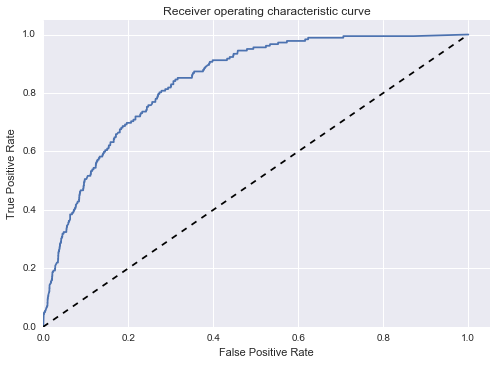

AUC: 0.840141


In [170]:
fpr,tpr, _ = roc_curve(y_test,y_predf)
roc_auc=auc(fpr,tpr)
plt.figure
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show()
print('AUC: %f' % roc_auc)

In [171]:
test_X_normalized=standnormalize(test_X)
y_predf=fmodel.predict(test_X_normalized)
y_probf=fmodel.predict_proba(test_X_normalized)

116224/116293 [============================>.] - ETA: 0s

In [172]:

finalSubmission= pd.DataFrame(kaggle_Submission)
finalSubmission['WnvPresent']=y_probf
finalSubmission.to_csv('kaggleSubmission19.csv',index=False)

# Kagle score 0.69599!!!
